# Modeling Demand for Cars with the IPDL model

In this notebook, we will explore the dataset used in
Goldberg & Verboven (2005). We will estimate the IPDL Model
model given the available data using the functions defined below.

Optimization terminated successfully.
         Current function value: 1.588275
         Iterations: 86
         Function evaluations: 87
         Gradient evaluations: 87


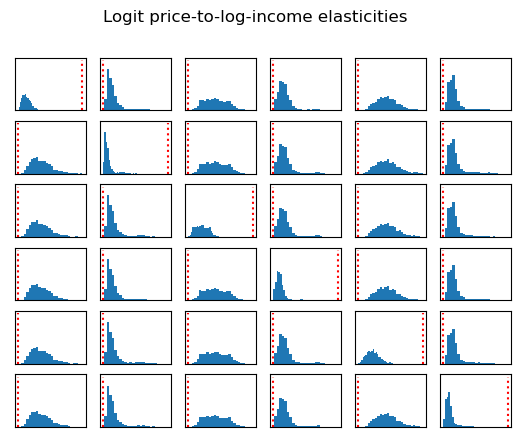

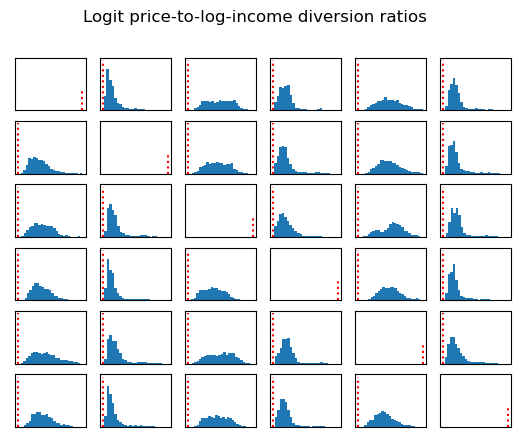

In [1]:
import numpy as np
import pandas as pd 
import os
from numpy import linalg as la
from scipy import optimize
from IPython import display
from matplotlib import pyplot as plt
import itertools as iter
from numba import jit

# Files
import Logit_file as logit

Data
====

The dataset consists of approximately 110 vehicle makes per year in the period 1970-1999 in five european markets (Belgium, France, Germany, Italy, and the United Kingdom). Furthermore, the data contains information on various characteristics of the makes such as sales, prices, horse power, weight and other physical car characteristics. Also these characteristics may vary across markets. 

A observation in our analysis will be a market in a given year such that e.g. the French car market in 1995 counts as a single observation. If $Y = 30$ is the number of years, and $M = 5$ is the number of country-level markets, we thus have $T=Y\cdot M = 150$ markets and observations. In addition, since the available vehicle makes vary across time and place, let $\mathcal{J}_t$ denote the set of available makes in each market $t=1,\ldots,T$, and let $\mathcal{J} := \bigcup_{t=1}^T \mathcal{J}_t$ be the set of all makes which were available in some market. Then $J:=\#\mathcal{J}$ is the number of makes which were available at some point of time in the period in at least one country-level market. In our dataset there are $J = 356$ unique vehicle makes. Note also however that characteristics of vehicle makes vary across markets.

Our dataset includes 47 variables in total. The first three columns are market and product codes for the year, country, and make. Another variable is quantity sold (No. of new registrations) which will be used in computing observed market shares. The remaining 43 variables are potential explanatory variables. We will only consider the subset of these which describes car characteristics such as brand, after-tax price, horse power, etc. which adds up to $K=20$ characteristics. The remaining 23 variables are mainly macroeconomic variables such as e.g. GDP per capita which have been used to construct estimates of e.g. the average wage income and purchasing power. Since we are only interested in utility-shifting variables, we will not consider the latter columns. 

Reading in the dataset `eurocars.csv` we thus have a dataframe of $\sum_{t=1}^T \#\mathcal{J}_t = 11459$ rows and $47$ columns. The `ye` column runs through $y=70,\ldots,99$, the `ma` column runs through $m=1,\ldots,M$, and the ``co`` column takes values $j\in \mathcal{J}$. 

Because we consider a country-year pair as the level of observation, we construct a `market` column taking values $t=1,\ldots,T$. We also construct a `market_share` variable giving us the market share of any product $j$ in any market $t$; this will obviously take values in $[0,1]$. To deal with the fact that choice sets $\mathcal{J}_t$ vary across markets, we expand the dataframe so that every car $j\in \mathcal{J}$ which was observed in some market $t$ is in the choice set of all other markets as well, i.e. we impose $\mathcal{J}_t = \mathcal{J}$ for all markets $t$. We then impute a market share of $q_{jt}=0$ for any car $j$ which in reality was not available in market $t$. To this end we first construct an outside option $j=0$ in each market $t$  of not buying a car by letting the 'sales' of $j=0$ being determined as 

$$\mathrm{sales}_{0t} = \mathrm{pop}_t - \sum_{j=1}^J \mathrm{sales}_{jt}$$

where $\mathrm{pop}_t$ is the total population in market $t$.

We also read in the variable description of the dataset contained in `eurocars.dta`. We will use the list `x_vars` throughout to work with our explanatory variables.

Lastly, we access the underlying 3-dimensional numpy array of the explonatory variables `x` by sorting on `market` and then `co`, and subsequently resizing the explanatory variables as

> `x = dat[x_vars].values.resize((T,J,K))`

In [2]:
# Load dataset and variable names
os.chdir('../GREENCAR_notebooks/')
input_path = os.getcwd() # Assigns input path as current working directory (cwd)
descr = (pd.read_stata('eurocars.dta', iterator = True)).variable_labels()
dat = pd.read_csv(os.path.join(input_path, 'eurocars.csv'))

# Stuff

In [3]:
# Load dataset and variable names
os.chdir('../GREENCAR_notebooks/')
input_path = os.getcwd() # Assigns input path as current working directory (cwd)
dat = pd.read_csv(os.path.join(input_path, 'car_data.csv'))
lab = pd.read_csv(os.path.join(input_path, 'car_labels.csv'), index_col = 'variable')

In [5]:
dat['range'] = dat['range'] / 100                  # Hundreds of miles that the vehicle can travel between fuelings
dat['top_speed'] = dat['top_speed'] / 100          # Highest speed that the vehicle can attain, in hundreds of miles per hour
dat['size'] = dat['size'] / 10                     # Scaled categorical variable for numerical purposes
dat['acceleration'] = dat['acceleration'] / 10     # Measured in tens of seconds
dat['operating_cost'] = dat['operating_cost'] / 10 # Measured in tens of cents per mile

In [6]:
# variables to use as explanatory variables
x_vars = list(lab.iloc[3:-4].index.values) # variable names

In [7]:
# dimensions of data
N = dat.person_id.nunique()
J = dat.j.nunique()
K = len(x_vars)

In [8]:
# response and explanatory variables as numpy arrays
y = pd.get_dummies(dat['y'].values.reshape((N,J))[:,0]).to_numpy() # Convert y to an (N,J) array as the onehot encoding. All values are equal along axis=1 in dataframe. Becomes an (N,) array i.e. it is a vector.
x = dat[x_vars].values.reshape((N,J,K))

In [56]:
y0 = {n: dat[dat['person_id'] == n]['binary_choice'].values.reshape(J) for n in np.arange(N)}
x0 = {n: dat[dat['person_id'] == n][x_vars].values.reshape((J,K)) for n in np.arange(N)}

In [10]:
resbla = logit.estimate_logit(logit.q_logit, np.zeros(K,), y, x, False)

Optimization terminated successfully.
         Current function value: 1.588275
         Iterations: 86
         Function evaluations: 1914
         Gradient evaluations: 87


In [14]:
resbla['beta']

array([-0.18542506,  0.35009672, -0.71618605,  0.26110244, -0.44410179,
        0.93435906,  0.14334865,  0.50249246, -0.76796125,  0.4130642 ,
        0.81947069,  0.63611041, -1.43666858, -1.0168134 , -0.79894   ,
       -0.17902228,  0.19837366,  0.44293472,  0.34506319,  0.31312313,
        0.22854791])

In [33]:
nest_vars = ['suv', 'sports_car', 'station_wagon', 'truck', 'van', 'ev', 'cng', 'methanol']

In [34]:
lab

,label,description
variable,,
person_id,Person ID,Person identifier
rownum,Row num,Row number in the dataset
binary_choice,Binary choice,"Dummy, =1 if this row is the car that was chosen"
price_to_inc,Price/ln(income),"Purchase price in thousands of dollars, divide..."
range,Range,Hundreds of miles that the vehicle can travel ...
acceleration,Acceleration,"Seconds required to reach 30 mph from stop, in..."
top_speed,Top speed,"Highest speed that the vehicle can attain, in ..."
pollution,Pollution,Tailpipe emissions as fraction of comparable n...
size,Size,"0""mini, 0.1""subcompact, 0.2""compact, 0.3""mid-s..."


# Stuff

In [208]:
pd.DataFrame(descr, index=['description']).transpose().reset_index().rename(columns={'index' : 'variable names'})

,variable names,description
0,ye,year (=first dimension of panel)
1,ma,market (=second dimension of panel)
2,co,model code (=third dimension of panel)
3,zcode,alternative model code (predecessors and succe...
4,brd,brand code
5,type,name of brand and model
6,brand,name of brand
7,model,name of model
8,org,"origin code (demand side, country with which c..."
9,loc,"location code (production side, country where ..."


We now clean the data to fit our setup

In [209]:
### First we create the 'market' column 

dat = dat.sort_values(by = ['ye', 'ma'], ascending = True)
market_vals = [*iter.product(dat['ye'].unique(), dat['ma'].unique())]
market_vals = pd.DataFrame({'year' : [val[0] for val in market_vals], 'country' : [val[1] for val in market_vals]})
market_vals = market_vals.reset_index().rename(columns={'index' : 'market'})
dat = dat.merge(market_vals, left_on=['ye', 'ma'], right_on=['year', 'country'], how='left')

### Second we construct an outside option for each market t

outside_shares = dat.groupby('market', as_index=False)['qu'].sum()
outside_shares = outside_shares.merge(dat[['market', 'pop']], on = 'market', how='left').dropna().drop_duplicates(subset = 'market', keep = 'first')
outside_shares['qu'] = outside_shares['pop'] - outside_shares['qu']
outside_shares['co'] = 0
dat = pd.concat([dat, outside_shares])

# Potentially set characteristics equal to 0 for outside option. However consider different data types!

In [210]:
### Third we compute market shares for each product j in each market t 

dat['ms'] = dat.groupby('market')['qu'].transform(lambda x: x/x.sum())

In [211]:
# Determine explanatory variables and find variable description as 'x_lab'
x_vars =  [dat.keys()[k] for k in [*range(6,13), *range(14,22), *range(25,29)]]
nest_vars = [var for var in x_vars if (var != 'type')&(var != 'model')&(var != 'pr')] # we will nest on variables which are not price, brand, model.
nest_cont_vars = ['cy', 'hp', 'we', 'le', 'wi', 'he', 'li', 'sp', 'ac']
x_lab = (pd.DataFrame(descr, index=['description'])[x_vars].transpose().reset_index().rename(columns={'index' : 'variable names'}))

In [212]:
x_lab

,variable names,description
0,brand,name of brand
1,model,name of model
2,org,"origin code (demand side, country with which c..."
3,loc,"location code (production side, country where ..."
4,cla,class or segment code
5,home,domestic car dummy (appropriate interaction of...
6,frm,firm code
7,cy,cylinder volume or displacement (in cc)
8,hp,horsepower (in kW)
9,we,weight (in kg)


In [213]:
# Find the dimensions of Data
T = dat['market'].nunique()
J = np.array([dat[dat['market'] == t]['co'].nunique() for t in np.arange(T)])
K = len(x_vars)

We also convert our discrete explanatory variables to numerical variables

In [214]:
obj_columns = dat.select_dtypes(['object'])
for col in obj_columns:
    dat[col] = dat[col].astype('category').cat.codes.astype('float64') # Possibly a problem with Nan's being mapped to -1 ?

Additionally we fill Nan values with '$-1$' in remaining columns

In [215]:
dat = dat.fillna(-1)

We also scale values such that they lie in the interval $[-1,1]$. This has various numerical benefits. Also, this will not affect elasticities or diversion ratios, but semielasticities will be affected by the scaling.  

In [216]:
dat[x_vars] = dat[x_vars] / dat[x_vars].abs().max()

Finally, we will primarily use numpy data types and numpy functions in this notebook. Hence we store our response variable 'y' and our explanatory variables 'x' as numpy arrays.

In [217]:
# Create numpy arrays of response and explanatory variables
dat = dat.sort_values(by = ['market', 'co']) # Sort data so that reshape is successfull
x = {t: dat[dat['market'] == t][x_vars].values.reshape((J[t],K)) for t in np.arange(T)}
y = {t: dat[dat['market'] == t]['qu'].to_numpy().reshape((J[t])) for t in np.arange(T)}

In [218]:
dat['ms']

0        0.010357
1        0.013426
2        0.025701
3        0.029920
4        0.036442
           ...   
11544    0.002023
11545    0.004321
11546    0.009205
11547    0.002496
11548    0.004107
Name: ms, Length: 11549, dtype: float64

#### Multinomial Logit - for comparison
Estimating a Logit model via maximum likelihood with an initial guess of parameters $\hat \beta^0 = 0$ yields estimated parameters $\hat \beta^{\text{logit}}$ given as...

In [219]:
beta_0 = np.ones((K,))

# Estimate the model
res_logit = logit.estimate_logit(logit.q_logit, beta_0, y, x, Analytic_jac=False)

         Current function value: 4.355613
         Iterations: 125
         Function evaluations: 4251
         Gradient evaluations: 212


In [220]:
logit_beta, logit_se = res_logit['beta'], res_logit['se']
pd.DataFrame({'parameters': logit_beta, 'se' : logit_se}) # Our estimates

,parameters,se
0,-6.024925e-09,1.907845e-06
1,-8.782760e-09,1.097027e-06
2,-1.685200e-08,3.122791e-06
3,1.824290e-08,4.510652e-06
4,8.738417e-09,5.655853e-06
5,-6.607248e-10,4.424442e-07
6,-2.987810e-09,2.565864e-06
7,-1.455490e-08,1.386535e-06
8,-2.119079e-08,3.016111e-06
9,3.849438e-09,1.164375e-05


We then compute the corresponding Logit choice probabilities. STILL FIX THIS PART IN LOGIT BOOK!!!

In [221]:
logit_q = logit.logit_ccp(logit_beta, x)

We also find the elasticities and diversion ratios implied by the logit model as follows...

In [222]:
epsilon_logit = logit.logit_elasticity(logit_q, logit_beta, 0) # Elasticities wrt. the price-to-log-income characteristic
#DR_logit_hat = logit.logit_diversion_ratio(logit_q, logit_beta)

# The IPDL model - Nesting structure

The IPDL model is a generalization of the nested logit model where each alternative may belong to more than one nest. Before fully introducing the model, we construct the nesting structure.


## Constructing nests

Let $\Delta=\left\{q\in \mathbb{R}^J_+: \sum_{j=1}^J q_j=1\right\}$ denote the probability simplex. For each group of nests $g=1,\ldots, G$, nest membership is denoted by the matrix $\Psi^g\in \mathbb R^{C_g\times J}$: $\Psi^g_{cj}=1$ if product $j$ belongs to nest $c$ and zero otherwise, and each product can only belong to one nest within each group, meaning that $\sum_{c=1}^{C_g}\Psi^g_{cj}=1$ for all $j$ and all $g$. The matrix-vector product $\Psi^gq$ is then
$$
\Psi^g q=\sum_j \Psi^{g}_{cj}q_j=\left(\begin{array}{c}
\sum_{j:\Psi^g_{1j}=1} q_j \\
\vdots \\
\sum_{j: \Psi^g_{C_gj}=1}q_j
\end{array}\right),
$$
and the vector $\Psi^gq$ is a vector of nest-specific choice probabilities, i.e. the sum of the probabilities within each nest.

### The perturbation function $\Omega$

In the following, a vector $z\in \mathbb R^d$ is always a column vector. We now construct the IPDL perturbation function which has the form (where for a vector $z$, the logarithm is applied elementwise and $z'$ denote the transpose)
$$
\Omega(q|\lambda)= (1-\sum_{g=1}^G \lambda_g) q'\ln q +\sum_{g=1}^{G} \lambda_g \left(\Psi^g q \right)'\ln \left(\Psi^g q\right).
$$
Note that since $\Psi^g q$ denotes a probability distribution over the nests, the term $(\Psi^gq)'\ln (\Psi^gq)$ is the (negative) entropy of the probability distribution $\Psi^g q$. Similarly, $q'\ln q$ is the negative entropy of q. Note also that as each nest has at least one member, and $q$ is strictly positive, $\Psi^gq$ is also strictly positive. When the parameters $\lambda_g$ satisfy $\lambda_g>0$ and
$$
\sum_g \lambda_g<1,
$$
the function $\Omega(\cdot|\lambda)$ is a strictly convex function of $q$, and the utility maximization problem has a unique interior (meaning strictly positive choice probabilities) solution. If $\lambda_g = 0$ for all groupings $g$, we immediately see that the  IPDL becomes the standard multinomial Logit model for the choice probabilities $q$. When there is only one group of nests, $G=1$, then $\Omega$ induces the nested logit choice probabilities (note though that the nested logit model is often parameterized in terms of the nesting parameter $\mu=1-\lambda$ instead!). 

It will be convenient to define a choice probability function for a given vector of payoffs $u$ as
$$
P(u|\lambda)=\arg \max_{q\in \Delta}\left\{q'u-\Omega(q|\lambda)\right\}
$$
Letting $\theta$ denote the full vector of parameters, $\theta=(\beta',\lambda')'$, the individual choice probabilities is a function of the matrix $\mathbf{X}_i$ and the parameters $\theta$, as
$$
p(\mathbf{X}_i,\theta)=\arg\max_{q\in \Delta}\left\{q'\mathbf{X}_i \beta-(1-\sum_{g=1}^G\lambda_g)q'\ln q-\sum_{g=1}^G\lambda_g \left(\Psi^g q \right)'\ln \left(\Psi^g q\right)\right\}
$$

# Max-rescaling for numerical stability

Let $\alpha$ be a scalar, and let $\iota$ be the all-ones vector in $\mathbb R^J$. Note that $q'(u+\alpha\iota)=q'u+(q'\iota)\alpha=q'u+\alpha$, since $q$ sums to one. For this reason, $\alpha$ does not enter into the utility maximization when calculating $P(u+\alpha\iota|\lambda)$, and we have $P(u+\alpha\iota|\lambda)=P(u|\lambda)$.

This allows us to re-scale the utilities just as in the logit model, since $P(u-(\max_{j}u_j)\iota|\lambda)=P(u|\lambda)$. The numerical benefits of this approach carry over to the IPDL model.

## Gradient and Hessian

For purposes of computing the gradient and Hessian of $\Omega$, it is convenient to define
$$
\Gamma=\left(\begin{array}{c}
(1-\sum_g \lambda_g)I_J\\
\lambda_1 \Psi^1\\
\vdots\\
\lambda_G \Psi^G
\end{array}\right)
$$
where $I_J$ is the identity matrix in $\mathbb R^J$. The matrix $\Gamma$ is a block matrix with $J+\sum_g C_g$ rows and $J$ columns. Note that 

$$
\Gamma q=\left(\begin{array}{c}
(1-\sum_g\lambda_g)q \\
\lambda_1\Psi^g q\\
\vdots \\
\lambda_G \Psi^Gq
\end{array}\right)>0
$$
if $q>0$.

Using $\Gamma$, we can show that
$$
\Omega(q|\lambda)=(\Gamma q)'\ln (\Gamma q)+c\\
\nabla_q \Omega(q|\lambda)=\Gamma'\ln (\Gamma q)+\iota\\
\nabla^2_{qq}\Omega(q|\lambda)=\Gamma'\mathrm{diag}(\Gamma q)^{-1}\Gamma,
$$
where $c$ is a scalar that depends on $\lambda$ but not on $q$ and therefore does not affect the utility maximization problem, $\iota=(1,\ldots,1)'\in \mathbb R^J$ is the all-ones vector and $\mathrm{diag}(z)$ is a diagonal matrix with the elements of the vector $z$ on the diagonal.

In the following we impose on all nests on all markets. We deal with this by setting $\psi_{tcj} = 0$ for all products $j$ if the nest $c$ was not in fact observed in market $t$.

In [106]:
def Create_nests(data, markets_id, products_id, columns, cont_var = None, cont_var_bins = None):
    '''
    This function creates the nest matrices \Psi^g from any specified columns in data

    Args.
        data: a pandas DataFrame
        markets_id: a string denoting the column of 'data' containing an enumeration t=0,1,...,T-1 of markets
        products_id: a string denoting the column of 'data' containing product code which uniquely identifies products
        columns: a list containing the column names of columns in 'data' from which nest groupings g=0,1,...,G-1 for each market t are to be generated
        cont_var: a list of the continuous variables in 'columns'
        caont_var_bins: a list containing the number of bins to make for each continuous variable in 'columns'

    Returns
        Psi_dict: a dictionary of dictionaries of the Psi_g matrices for each market t and each gropuing g
        nest_dict: a dictionary of dictionaries of pandas dataframes describing the structure of each nest for each market t and each grouping g 
    '''

    T = data[markets_id].nunique()
    J = np.array([data[data[markets_id] == t][products_id].nunique() for t in np.arange(T)])
    G = len(columns)

    dat = data.sort_values(by = [markets_id, products_id]) # This is good :)
    
    Psi_dict = {}
    Psi_stack = {}
    nest_dict = {}
    nest_counts = {}

    ### Bin continuous variables

    if cont_var == None:
        None
    else:
        for var,n_bins in zip(cont_var,cont_var_bins):
            dat[var] = pd.cut(dat[var], bins=n_bins, labels=[str(i) for i in range(1,n_bins +1)], include_lowest=True)

    # Assign nests for products in each market t
    for t in np.arange(T):
        data_t = dat[dat[markets_id] == t]
        Psi_dict_t = {}
        nest_dict_t = {}
        nest_counts_t = np.empty(G)

        for g in np.arange(G):
            col = columns[g]
            vals = pd.DataFrame({'nests' : data_t[col].sort_values().unique()}).reset_index().rename(columns={'index' :'nest_index'})
            descr = vals.rename_axis(col, axis='columns')
            nest_dict_t[g] = descr
            nest_counts_t[g] = len(vals['nests'])
            product_enumeration = pd.DataFrame({products_id : data_t[products_id].sort_values().unique(), 'product_enumeration' : np.arange(J[t])})
            C_g = data_t[col].nunique()

            frame = data_t[[products_id, col]].merge(vals, left_on = col, right_on = 'nests')
            allocation = frame[[products_id, 'nest_index']].merge(product_enumeration, on=products_id, how='left')

            mat = np.zeros((int(C_g), J[t]))

            for c,j in zip(allocation['nest_index'], allocation['product_enumeration']):
                mat[c, j] = 1

            Psi_dict_t[g] = mat

        Psi_dict[t] = Psi_dict_t
        nest_dict[t] = nest_dict_t
        nest_counts[t] = nest_counts_t
        Psi_stack[t] = np.concatenate([np.eye(J[t]) if g==0 else Psi_dict[t][g-1] for g in np.arange(G + 1)])
        
    return Psi_stack, Psi_dict, nest_dict, nest_counts

In [38]:
psi0, psi0dict, nestdict, nestcounts =  Create_nests(dat, 'person_id', 'j', nest_vars)

We bin all the continuous explanatory variables different from `pr` (i.e. the price) in 10 bins, and the grouping of `pr` includes 100 bins.

In [224]:
Psi_stack, Psi_dict, Nest_descr, Nest_count = Create_nests(dat, 'market', 'co', nest_vars, nest_cont_vars, [*[np.int64(10) for i in range(len(nest_cont_vars))]])

In [107]:
def Create_Gamma(Lambda, psi_stack, nest_count):
    '''
    This function 
    '''

    T = len(psi_stack.keys())

    Gamma = {}
    lambda0 = 1 - sum(Lambda)
    Lambda_full = [lambda0, *Lambda]

    for t in np.arange(T):
        J = np.int64(psi_stack[t].shape[1])
        C = np.int64(J + np.sum(nest_count[t]))
        Lambda_long = np.empty((C))
        indices = np.concatenate([np.array([J]),nest_count[t]]).cumsum().astype('int')

        for i in np.arange(len(indices)):
            if i == 0:
                Lambda_long[0:(indices[i])] = Lambda_full[i]
            else:
                Lambda_long[indices[i-1]:indices[i]] = Lambda_full[i]
    
        Gamma[t] =  np.multiply(Lambda_long[:,None], psi_stack[t])

    return Gamma

In [17]:
G = len(nest_vars)
lambda0 = np.ones((G,))/(G+1)
Gamma0 = Create_Gamma(lambda0, Psi_stack, Nest_count)

NameError: name 'nest_vars' is not defined

## Model solution

While it is possible to solve for the choice probabilities explicitly by maximizing utility, Fosgerau and Nielsen (2021) suggest a contraction mapping approach which is conceptually simpler. Suppose we are evaluating the likelihood at some guess of the parameters $\theta=(\beta',\lambda')$. Let $u_i=\mathbf{X}_i\beta$, and let $q_i^0$ denote some initial vector of choice probabilities e.g. $q^0_i=\frac{e^{u_i}}{\sum_{j'=1}^Je^{u_{ij'}}}$, we update the choice probabilities according to the formula
$$
v_i^{k} =u_i+\ln q_i^{k-1}-\Gamma'\ln (\Gamma q_i^{k-1})\\
q_i^{k} = \frac{e^{v_i^{k}}}{\sum_{j=1}^J e^{v_{ij}^{k}}},
$$
they show that $\lim_{k\rightarrow \infty}q_i^k=p(\mathbf{X}_i,\theta)$ for any starting value $q^0_i$ in the interior of $\Delta$. For numerical stability, it can be a good idea to also do max-rescaling of $v^k_i$ at every iteration.

Let $p$ denote the solution to the utility maximization problem. Formally, the Kullback-Leibler divergence $D_{KL}(p||q)=p'\ln \frac{p}{q}$ decays linearly with each iteration,
$$
D_{KL}(p||q^{k+1})\leq \left(1- \sum_g \lambda_g \right)D_{KL}(p||q^k),
$$
Noting that $(1-\sum_g \lambda_g)\in [0,1)$ by assumption.

In [119]:
def IPDL_ccp(Beta, x, Gamma, tol = 1.0e-15, maximum_iterations = 1000, MAXRESCALE:bool = True):
    ''' 
    '''

    T = len(x)

    u = {t: np.dot(x[t], Beta) for t in np.arange(T)}
    q = {t: np.exp(u[t]) / np.exp(u[t]).sum() for t in np.arange(T)} # Find logit choice probabilities
    q0 = q
    
    Epsilon = 1.0e-8

    for k in range(maximum_iterations):
        q1 = {}
        for t in np.arange(T):
            # Calculate v
            gamma_q = np.dot(Gamma[t], q0[t])
            log_gammaq = np.log(gamma_q)
            gamma_log_prod = np.dot(np.transpose(Gamma[t]), log_gammaq) # Maybe multiply with active_mat???
            v = u[t] + np.log(q0[t]) - gamma_log_prod

            # Calculate iterated ccp q^k
            denom = np.exp(v).sum()
            numerator = np.exp(v)
            q1[t] = np.divide(numerator, denom) 

        # Check convergence in an appropriate distance function
        dist = np.max(np.array([np.sum((q1[t]-q0[t])**2/q[t]) for t in np.arange(T)])) # Uses logit weights. This avoids precision issues when q1~q0~0.

        if dist<tol:
            break
        elif k==maximum_iterations:
            break
        else:
            None
            
        # Iteration step
        q0 = q1

    return q1 

In [228]:
theta0 = np.append(logit_beta, lambda0)

q0_hat = IPDL_ccp(logit_beta, x, Gamma0)
pd.DataFrame(q0_hat[0]).rename_axis(index='Products', columns='Markets')

Markets,0
Products,
0,0.001590
1,0.014996
2,0.018420
3,0.002039
4,0.002451
...,...
60,0.016435
61,0.011855
62,0.018422


In [229]:
theta0[K-1]

-1.2670644531880878e-08

In [230]:
assert np.array([np.sum(q0_hat[t]) for t in np.arange(T)]).all() == 1

## Demand derivatives and price Elasticity

While the demand derivatives in the IPDL model are not quite as simple as in the logit model, they are still easy to compute. 
Let $q=P(u|\lambda)$, then
$$
\nabla_u P(u|\lambda)=\left(\nabla^2_{qq}\Omega(q|\lambda)\right)^{-1}-qq'
$$
where the $()^{-1}$ denotes the matrix inverse. The derivatives with respect to any $x_{ij\ell}$ can now easily be computed by the chain rule,
$$
    \frac{\partial P_j(u_i|\lambda)}{\partial x_{ik\ell}}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\frac{\partial u_{ik}}{\partial x_{ik\ell}}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\beta_\ell,
$$

Finally, moving to price elasticity is the same as in the logit model, if $x_{ik\ell}$ is the log price of product $k$ for individual $i$, then
$$
    \mathcal{E}_{jk}= \frac{\partial P_j(u_i|\lambda)}{\partial x_{ik\ell}}\frac{1}{P_j(u_i|\lambda)}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\frac{1}{P_j(u_i|\lambda)}\beta_\ell=\frac{\partial \ln P_j(u_i|\lambda)}{\partial u_{ik}}\beta_\ell$$
we can also write this compactly as
$$
\nabla_u \ln P(u|\lambda)=\mathrm{diag}(P(u|\lambda))^{-1}\nabla_u P(u|\lambda).
$$

In [123]:
def compute_pertubation_hessian(q, x, Theta, psi_stack, nest_count):
    '''
    This function calucates the hessian of the pertubation function \Omega

    Args.
        q: a (N,J) numpy array of choice probabilities
        Lambda: a (G,) numpy array of nesting parameters
        Psi: a dictionary of the \Psi^g matrices as columns as outputted 'Create_incidence_matrix'
    
    Returns
        Hess: a (N,J,J) numpy array of second partial derivatives of the pertubation function \Omega
    '''
    
    T = len(x.keys())
    K = x[0].shape[1]

    Gamma = Create_Gamma(Theta[K:], psi_stack, nest_count)
    Hess = {}

    for t in np.arange(T):
        gamma_q = np.dot(Gamma[t], q[t])
        inv_gamma_q = la.inv(np.diag(gamma_q))
        Hess[t] = np.dot(np.transpose(Gamma[t]), np.dot(inv_gamma_q, Gamma[t]))

    return Hess

In [124]:
def ccp_gradient(q, x, Theta, psi_stack, nest_count):
    '''
    This function calucates the gradient of the choice proabilities wrt. characteristics

    Args.
        q: a (N,J) numpy array of choice probabilities
        x: a (N,J,K) numpy array of covariates
        Lambda: a (G,) numpy array of nesting parameters
        Psi: a dictionary of the \Psi^g matrices as columns as outputted 'Create_incidence_matrix'
    
    Returns
        Grad: a (N,J,K) numpy array of partial derivatives of the choice proabilities wrt. characteristics
    '''

    T = len(x.keys())
    Grad = {}
    Hess = compute_pertubation_hessian(q, x, Theta, psi_stack, nest_count)

    for t in np.arange(T):
        inv_omega_hess = la.inv(Hess[t]) # (N,J,J) # For each i=1,...,N , computes the inverse of the J*J Hessian
        qqT = np.outer(q[t], q[t]) # (N,J,J) outerproduct
        Grad[t] = inv_omega_hess - qqT

    return Grad

In [125]:
def IPDL_u_grad_Log_ccp(q, x, Theta, psi_stack, nest_count):
    '''
    This function calucates the gradient of the log choice proabilities wrt. characteristics

    Args.
        q: a (N,J) numpy array of choice probabilities
        x: a (N,J,J) numpy array of covariates
        Theta: a (K+G,) numpy array of IPDL parameters
        Psi: a dictionary of the \Psi^g matrices as columns as outputted 'Create_incidence_matrix'
    
    Returns
        Epsilon: a (N,J,K) numpy array of partial derivatives of the log choice proabilities wrt. characteristics
    '''

    T = len(x.keys())
    Epsilon = {}
    Grad = ccp_gradient(q, x, Theta, psi_stack, nest_count)
    
    for t in np.arange(T):
        ccp_grad = Grad[t]
        inv_q = np.divide(1, q[t])
        Epsilon[t] = np.multiply(inv_q, ccp_grad) # Is equivalent to (1./q)[:,:,None]*ccp_grad an elementwise product. Einsum merely divides through by the nj'th elemnt of q in k'th row of ccp_grad.

    return Epsilon

In [126]:
def IPDL_elasticity(q, x, Theta, psi_stack, nest_count, char_number = K-1):
    ''' 
    This function calculates the elasticity of choice probabilities wrt. any characteristic or nest grouping of products

    Args.
        q: a (N,J) numpy array of choice probabilities
        x: a (N,J,K) numpy array of covariates
        Theta: a (K+G,) numpy array of IPDL parameters
        Psi: a dictionary of the \Psi^g matrices as columns as outputted 'Create_incidence_matrix'
        char_number: an integer which is an index of the parameter in theta wrt. which we wish calculate the elasticity 

    Returns
        an (N,J,J) array of choice probability elasticities
    '''
    T = len(x.keys())
    Epsilon = {}
    Grad = IPDL_u_grad_Log_ccp(q, x, Theta, psi_stack, nest_count)

    for t in np.arange(T):
        Epsilon[t] = np.multiply(Grad[t], Theta[char_number])

    return Epsilon

Using guess parameters $\hat \theta^0$ we calculate price-to-log-income elasticities for individual $i=0$. 

In [235]:
pd.DataFrame(IPDL_elasticity(q0_hat, x, theta0, Psi_stack, Nest_count)[0])

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-2.104232e-07,2.172974e-10,3.952816e-11,5.577542e-10,5.363524e-10,-5.228385e-10,-1.168396e-10,2.119287e-09,2.909595e-09,2.114180e-09,...,4.712515e-10,6.055531e-10,-5.658055e-10,2.303069e-09,6.367901e-10,-1.270671e-10,5.095305e-09,-6.702771e-10,-1.136041e-11,1.301214e-09
1,2.049312e-09,-1.149671e-07,4.361730e-08,8.249023e-09,-5.000707e-10,7.157769e-10,-5.917176e-10,-2.438724e-10,1.356822e-09,2.420217e-09,...,2.617723e-09,9.092793e-10,-7.373786e-10,2.129364e-09,9.326265e-10,4.309833e-11,8.874294e-10,1.510659e-09,1.377561e-10,-8.951490e-11
2,4.579154e-10,5.357766e-08,-1.027393e-07,5.323672e-09,-6.260485e-09,1.745363e-10,-9.871213e-10,-4.352642e-09,-3.648675e-09,2.561593e-10,...,-2.433134e-10,-1.106246e-09,-3.922351e-09,3.523917e-09,1.086148e-09,8.259683e-09,-5.267016e-09,-1.821468e-09,-3.494007e-10,1.851605e-09
3,7.152624e-10,1.121686e-09,5.893255e-10,-2.037512e-07,2.704215e-10,-2.752501e-10,-8.366119e-11,-4.382579e-10,-1.642489e-09,-3.034704e-10,...,7.808987e-10,-5.584572e-11,1.411761e-10,2.271752e-09,-4.000495e-10,-5.729893e-10,-3.994528e-10,7.582466e-10,-2.005285e-10,2.859766e-09
4,8.267004e-10,-8.172891e-11,-8.329660e-10,3.250248e-10,-1.951228e-07,2.361777e-09,9.800303e-11,1.569430e-08,-1.560142e-10,4.249034e-10,...,-5.020747e-10,-3.425566e-10,1.752776e-09,5.166331e-10,5.478521e-10,5.323760e-10,-2.208111e-09,3.650447e-09,-5.784503e-10,3.395057e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,-1.313350e-09,4.723393e-11,7.369398e-09,-4.618183e-09,3.569997e-09,1.430701e-09,4.862783e-10,3.461490e-09,1.237567e-09,-2.183366e-10,...,1.491483e-09,2.055380e-09,1.271274e-08,8.750408e-09,-1.612615e-10,-6.692436e-08,1.219929e-09,2.031818e-10,7.109987e-10,-1.644651e-09
61,3.798958e-08,7.015756e-10,-3.389848e-09,-2.322401e-09,-1.068113e-08,2.524559e-09,-6.880047e-10,-1.218431e-08,1.648007e-08,-8.416066e-10,...,2.310069e-10,2.272229e-10,-2.705931e-09,1.961958e-10,-3.374781e-10,8.799980e-10,-1.260200e-07,2.394188e-08,-5.695582e-10,-2.860223e-09
62,-7.765611e-09,1.855812e-09,-1.821647e-09,6.850293e-09,2.743907e-08,2.295326e-10,-1.730110e-10,3.676188e-08,9.422624e-09,-1.433264e-09,...,-6.354272e-09,-6.363200e-10,4.338963e-09,8.101100e-09,-8.212003e-10,2.277503e-10,3.720362e-08,-9.236781e-08,1.278199e-10,1.327248e-08
63,-1.912905e-10,2.459556e-10,-5.078609e-10,-2.633013e-09,-6.319282e-09,3.154184e-10,4.311945e-09,-4.926535e-09,1.532898e-09,1.223884e-08,...,-1.164691e-09,-9.617953e-10,1.451532e-10,-7.376800e-10,-2.957596e-10,1.158300e-09,-1.286303e-09,1.857705e-10,-4.653795e-08,8.306782e-09


## Maximum likelihood estimation of IPDL

The log-likelihood contribution is
$$
\ell_t(\theta)=y_t'\ln p(\mathbf{X}_t,\theta),
$$
and an estimation routine must therefore have a function that - given $\mathbf{X}_t$ and $\theta$ - calculates $u_t=\mathbf{X}_t\beta$ and constructs $\Gamma$, and then calls the fixed point routine described above. That routine will return $p(\mathbf{X}_t,\theta)$, and we can then evaluate $\ell_t(\theta)$. Using our above defined functions we now construct precisely such an estimation procedure.

For maximizing the likelihood, we want the derivates at some $\theta=(\beta',\lambda')$. Let $q_t=p(\mathbf{X}_t,\theta)$, then we have
$$
\nabla_\theta \ln p(\mathbf{X}_t,\theta)=\mathrm{diag}(q_t)^{-1}\left(\nabla_{qq}^2\Omega(q_t|\lambda)^{-1}-q_tq_t' \right)\left[\mathbf{X}_t,-\nabla_{q,\lambda}^2 \Omega(q_t|\lambda)\right]
$$
Note that the first two components is the elasticity $\nabla_u \ln P(u|\lambda)$ and the last term is a block matrix of size $J\times dim(\theta)$. Note that the latter cross derivative $\nabla_{q,\lambda}^2 \Omega(q_t|\lambda)$ is given by $\nabla_{q,\lambda}^2 \Omega(q_t|\lambda)_g = \ln(q) - \Psi^g \ln(\Psi^g q)$ for each row $g=1,\ldots,G$. The derivative of the log-likelihood function can be obtained from this as
$$
\nabla_\theta \ell_t(\theta)=\nabla_\theta \ln p(\mathbf{X}_t,\theta)' y_t \\
$$

In [127]:
def IPDL_loglikelihood(Theta, y, x, psi_stack, nest_count):
    ''' 
    This function computes the loglikehood contribution for each individual i.
    
    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        y: a numpy array (N,J) of observed choices in onehot encoding,
        x: a numpy matrix (N,J,K) of covariates,
        Psi: a dictionary of the matrices \psi^g as columns as outputted by 'Create_incidence_matrix'

    Output
        ll: a numpy array (N,) of IPDL loglikelihood contributions
    '''

    T = len(x.keys())
    K = x[0].shape[1]
    gamma = Create_Gamma(Theta[K:], psi_stack, nest_count)
    ccp_hat = IPDL_ccp(Theta[:K], x, gamma)
    ll = np.empty(T)

    for t in np.arange(T):
        ll[t] = np.dot(y[t], np.log(ccp_hat[t]))

    return ll

In [128]:
G = len(nest_vars)
lambda0 = np.ones((G,)) / (2*(G+1))
beta0 = resbla['beta']
theta0 = np.append(beta0, lambda0)
np.mean(IPDL_loglikelihood(theta0, y0, x0, psi0, nestcounts))

-1.6484400316247945

In [ ]:
[]

In [118]:
u0 = logit.util(beta0, x0)
q0 = {t: np.exp(u0[t]) / np.exp(u0[t]).sum() for t in np.arange(N)}
all(q0[n].sum().all() == 1 for n in np.arange(N))

True

In [92]:
lambda0.sum()

0.8888888888888888

In [129]:
def q_IPDL(Theta, y, x, psi_stack, nest_count):
    ''' 
    '''
    Q = -IPDL_loglikelihood(Theta, y, x, psi_stack, nest_count)
    
    return Q

We also implement the derivative of the loglikehood wrt. parameters $\nabla_\theta \ell_t(\theta)$.

In [130]:
def cross_grad_pertubation(q, psi_stack, nest_count):
    ''' 
    '''

    T = len(q.keys())
    log_q = {t: np.log(q[t]) for t in np.arange(T)}
    Z = {}
    
    for t in np.arange(T):
        G = len(nest_count[t])
        indices = np.int64(np.cumsum(nest_count[t]))
        J = np.int64(psi_stack[t].shape[0] - np.sum(nest_count[t]))
        Z_t = np.empty((J,G))
        for g in np.arange(G):

            if g == 0:
                Psi = psi_stack[t][J:J+indices[g],:]
            else:
                Psi = psi_stack[t][J+indices[g-1]:J+indices[g],:]

            Psi_q = np.dot( Psi, q[t])
            log_Psiq = np.log(Psi_q) # IS THIS THE RIGHT WAY TO HANDLE 0's ??? Should be set to 0 if input is 0 since no info is gained from the nest or car if they were not active in the market
            Psi_logPsiq = np.dot(np.transpose(Psi), log_Psiq) # possibly hadamard multiply with active_mat ???

            Z_t[:,g] = log_q[t] - Psi_logPsiq
        
        Z[t] = Z_t
    
    return Z

In [131]:
def IPDL_theta_grad_log_ccp(Theta, x, psi_stack, nest_count):
    ''' 
    '''

    T = len(x.keys())
    K = x[0].shape[1]

    Gamma = Create_Gamma(Theta[K:], psi_stack, nest_count)
    q = IPDL_ccp(Theta[:K], x, Gamma)

    Z = cross_grad_pertubation(q, psi_stack, nest_count)
    G = [np.concatenate((x[t], -Z[t]), axis=1) for t in np.arange(T)]

    u_grad = IPDL_u_grad_Log_ccp(q, x, Theta, psi_stack, nest_count)

    Grad = {t: np.dot(u_grad[t], G[t]) for t in np.arange(T)} # np.einsum('tjk,tkd->tjd', u_grad, G)

    return Grad

In [132]:
def IPDL_score(Theta, y, x, psi_stack, nest_count):
    ''' 
    '''
    T = len(x.keys())

    log_ccp_grad = IPDL_theta_grad_log_ccp(Theta, x, psi_stack, nest_count)
    D = log_ccp_grad[0].shape[1]
    Score = np.empty((T,D))
    
    for t in np.arange(T):
        Score[t,:] = np.dot(y[t], log_ccp_grad[t])

    return Score

In [133]:
def q_IPDL_score(Theta, y, x, psi_stack, nest_count):
    ''' 
    '''

    return -IPDL_score(Theta, y, x, psi_stack, nest_count)

## Standard errors in Maximum Likelihood estimation

As usual we may consistently estimate the Covariance Matrix  of the IPDL maximum likelihood estimator for some estimate $\hat \theta = (\hat \beta', \hat \lambda')'\in \mathbb{R}^{K+G}$ as:

$$
\hat \Sigma = \left( \sum_{i=1}^N \nabla_\theta \ell_i (\hat \theta) \nabla_\theta \ell_i (\hat \theta)' \right)^{-1}
$$

Thereby we may find the estimated standard error of parameter $d$ as the squareroot of the d'th diagonal entry of $\hat \Sigma$:

$$
\hat \sigma_d = \sqrt{\hat \Sigma_{dd}}
$$

In [134]:
def IPDL_se(score):
    ''' 
    '''

    SE = np.sqrt(np.diag(la.inv(np.einsum('td,tm->dm', score, score))))

    return SE

### We now estimate the model

In [135]:
def estimate_IPDL(f, Theta0, y, x, psi_stack, nest_count, Analytic_jac:bool = True, options = {'disp': True}, **kwargs):
    ''' 
    Takes a function and returns the minimum, given start values and 
    variables to calculate the residuals.

    Args:
    f: a function to minimize,
    Theta0 : (K+G,) array of initial guess parameters,
    y: a numpy array (N,J) of observed choices in onehot encoding,
    x: array of observed explanatory variables (N,J,K),
    Psi: dictionary of nesting distributions outputted by 'Create_incidence_matrix',
    Analytic_jac: a boolean. Default value is 'True'. If 'True' the analytic jacobian of the IPDL loglikelihood function is used in estimation. Else the numerical jacobian is used.
    options: dictionary with options for the optimizer (e.g. disp=True,
        which tells it to display information at termination.)
    
    Returns:
        res: a dictionary with results from the estimation.
    '''

    # The objective function is the average of q(), 
    # but Q is only a function of one variable, theta, 
    # which is what minimize() will expect
    Q = lambda Theta: np.mean(f(Theta, y, x, psi_stack, nest_count))

    if Analytic_jac == True:
        Grad = lambda Theta: np.mean(q_IPDL_score(Theta, y, x, psi_stack, nest_count), axis=0) # Finds the Jacobian of Q. Takes mean of criterion q derivatives along axis=0, i.e. the mean across individuals.
    else:
        Grad = None

    # call optimizer
    result = optimize.minimize(Q, Theta0.tolist(), options=options, jac=Grad, **kwargs) # optimize.minimize takes a list of parameters Theta0 (not a numpy array) as initial guess.

    # collect output in a dict 
    res = {
        'theta': result.x,
        'se': IPDL_se(IPDL_score(result.x, y, x, psi_stack, nest_count)),
        'success':  result.success, # bool, whether convergence was succesful 
        'nit':      result.nit, # no. algorithm iterations 
        'nfev':     result.nfev, # no. function evaluations 
        'fun':      result.fun # function value at termination 
    }

    return res

In [138]:

resbla2 = estimate_IPDL(q_IPDL, np.append(beta0, lambda0), y0, x0, psi0, nestcounts, method = 'Nelder-Mead')

c:\Users\mgq977\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:522: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,
C:\Users\mgq977\AppData\Local\Temp\ipykernel_4568\893540970.py:18: RuntimeWarning: invalid value encountered in log
  log_gammaq = np.log(gamma_q)


KeyboardInterrupt: 

In [244]:
res_IPDL = estimate_IPDL(q_IPDL, theta0, y, x, Psi_stack, Nest_count)

C:\Users\mgq977\AppData\Local\Temp\ipykernel_12580\3000777871.py:18: RuntimeWarning: invalid value encountered in log
  log_gammaq = np.log(gamma_q + Epsilon)


KeyboardInterrupt: 

In [ ]:
IPDL_theta = res_IPDL['theta']
Theta_frame = pd.DataFrame({'theta' : IPDL_theta}, index = [*x_vars, *['group' + var for var in nest_vars]]).rename_axis(columns='variables')
#Theta_frame.to_csv('IPDL2_Theta.csv')

In [ ]:
Theta_frame

variables,theta
brand,-1.000000
model,-1.000000
org,-1.000000
loc,-1.000000
cla,-1.000000
home,-1.000000
frm,-1.000000
cy,-1.000000
hp,-1.000000
we,-1.000000
